### <b> Import Libraries and modules </b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
from sklearn.preprocessing import LabelEncoder
import joblib
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns


### <b> Load dataset </b>

In [2]:
df = DataFrame() 

LOS = pd.read_csv('LOS.csv',sep=',',parse_dates=True) #csv file
LOS

LOS.head() #first rows


,Gender,Ethnicity,Sector,District,Length of Stay,HealthcareWorker,WardUponAdmission,Hypertension,Diabetes,Asthma,...,ChronicPulmonaryDisease,ChronicRenalFailure,Malignancy,HivPositive,TuberculosisPast,Tuberculosis,Obesity,Risk Level,LOS_Category,Age_Group
0,Female,Black African,Public,Sarah Baartman,0,False,General Ward,No,No,No,...,No,No,No,Yes,No,No,Unknown,Moderate Risk,Short,30-39
1,Female,Black African,Public,Sarah Baartman,1,False,General Ward,Yes,No,No,...,No,No,No,No,Unknown,No,No,Moderate Risk,Short,80+
2,Female,Black African,Public,Chris Hani,1,False,General Ward,Yes,No,No,...,No,No,No,Unknown,Unknown,No,Unknown,Moderate Risk,Short,80+
3,Female,Black African,Public,Sarah Baartman,15,False,General Ward,No,No,No,...,No,No,No,Yes,Unknown,No,No,Moderate Risk,Long,40-49
4,Female,Black African,Public,Sarah Baartman,15,False,General Ward,No,No,No,...,No,No,No,No,Unknown,No,No,Low Risk,Long,30-39


#### <b> Data Preprocessing </b>

##### 1. Encoding X and Y

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming 'LOS' is your DataFrame and 'columns' is the list of feature columns
# Categorical columns for one-hot encoding
categorical_columns = ['Age_Group', 'Gender', 'Ethnicity', 'Sector', 'District', 'HealthcareWorker', 'WardUponAdmission', 'Hypertension', 'Diabetes',
       'Asthma', 'CardiacDisease', 'ChronicPulmonaryDisease','ChronicRenalFailure', 'Malignancy', 'HivPositive', 'TuberculosisPast',
       'Tuberculosis', 'Obesity', 'Risk Level']
label_column= 'LOS_Category'

# One-hot encoding for X columns
X_encoded = pd.get_dummies(LOS[categorical_columns])

# Convert boolean values to integers (0 or 1) if needed
X_encoded = X_encoded.astype(int)

# Label encoding for Y (DischargeStatus)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(LOS[label_column])


# Print encoded X and Y
#X_encoded.info()
print(Y_encoded)


[1 1 1 ... 1 1 1]


#### 2. OverSampling

In [4]:
import imblearn 
from imblearn.over_sampling import SMOTE

# Addressing class imbalances

# Perform oversampling using SMOTE
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_encoded, Y_encoded)

# Print the shape of resampled data to verify oversampling
print("Original data shape:", X_encoded.shape, Y_encoded.shape)
print("Resampled data shape:", X_resampled.shape, Y_resampled.shape)

Original data shape: (46051, 70) (46051,)
Resampled data shape: (80352, 70) (80352,)


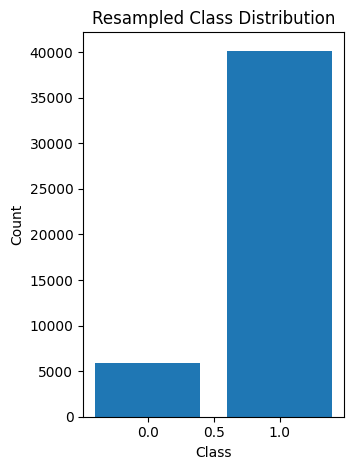

In [5]:
import matplotlib.pyplot as plt

# Count the occurrences of each class after oversampling
resampled_class_counts = pd.Series(Y_encoded).value_counts()


plt.subplot(1, 2, 2)
plt.bar(resampled_class_counts.index, resampled_class_counts.values)
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### 3. Training and Testing Sets - Dataset Split

In [6]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y_encoded, test_size=0.3, random_state=42)

# Print the shapes of the training and testing sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (32235, 70)
X_test shape: (13816, 70)
y_train shape: (32235,)
y_test shape: (13816,)


In [7]:
# Verify data is binary (0 or 1)
print("Unique values in X_train:", np.unique(X_train))
# Should print only [0, 1]

Unique values in X_train: [0 1]


#### 4. Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

X_test_scaled

array([[-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       ...,
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
        -1.05923563,  1.18451945],
       [-0.17846622, -0.1515787 , -0.17101878, ..., -0.14072841,
         0.944077  , -0.84422421]])

### <b>Model Training and Testing</b>

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=350, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Predict class labels
y_pred = xgb_model.predict(X_test_scaled)

# Predict probabilities for AUC
y_proba = xgb_model.predict_proba(X_test_scaled)

# Basic evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'binary' for binary classification
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# AUC Score (adjusted based on number of classes)
if len(np.unique(y_test)) == 2:
    auc = roc_auc_score(y_test, y_proba[:, 1])
else:
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')

# Print the metrics
print("XGBoost Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)


C:\Users\Taurai Chikotie\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:57:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Accuracy: 0.8697162709901564
Precision: 0.823273327644653
Recall: 0.8697162709901564
F1 Score: 0.8270215860881889
AUC Score: 0.6597789269888112


In [1]:
pip install imodels

Note: you may need to restart the kernel to use updated packages.


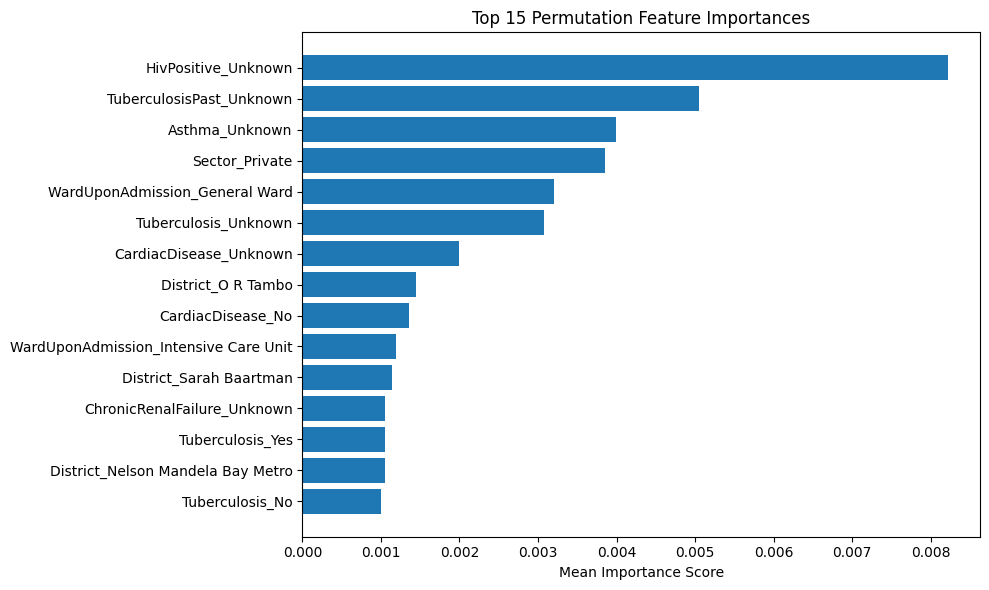

In [10]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgb_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Create dataframe
perm_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'][:15][::-1], perm_df['Importance'][:15][::-1])
plt.title("Top 15 Permutation Feature Importances")
plt.xlabel("Mean Importance Score")
plt.tight_layout()
plt.show()

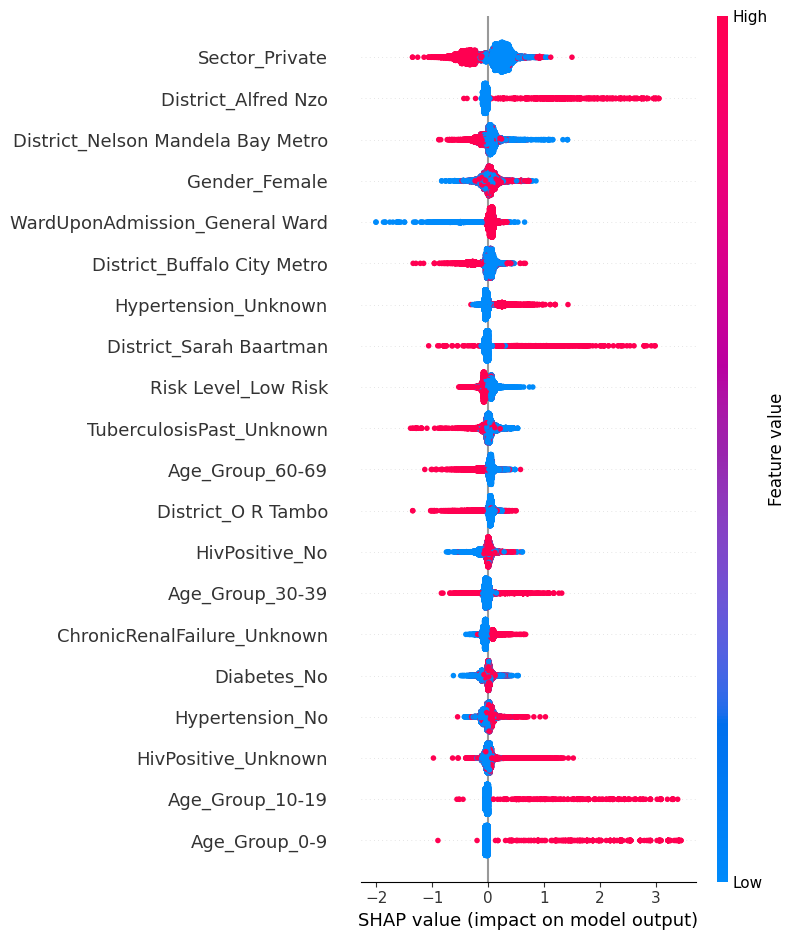

In [11]:
# 2. Import necessary libraries
import shap
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 3. Load your already-trained XGBoost model and test data
# Assume: xgb_model, X_test_scaled, X_encoded.columns already exist from your earlier code

# 4. Initialize SHAP
shap.initjs()

# 5. Create SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# 6. Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# 7. Global Summary Plot
# Shows overall feature importance and direction of influence (toward class 0 or 1)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_encoded.columns)